In [1]:
using  FITSIO, FITSTables, DataFrames, PyPlot, PyCall
LogNorm = pyimport("matplotlib.colors").LogNorm
include("get_lamost_spectra.jl")
include("fitsdf.jl")
include("lines_and_grid.jl")
;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
fn = "random_30000_all.classified.fits"
df = fitsdf(fn, 2);

In [3]:
df.enriched =  df.isline .& (df.EEW .> 0.15) .& (df.EEW_err .< 0.05);

In [4]:
lamost = FITS(DataFrame ∘ last, "../cats/LAMOST-dr5-v3-stellar.fits.gz")
enriched = join(df[df.enriched, :], lamost, on=:designation, kind=:left);

In [25]:
download_lamost_spectra(enriched.obsid, verbose=false)
spectra = []
ivar = []
bad_obsids = []
for obsid in enriched.obsid
    wl, flux, iv = load_lamost_spectrum(obsid, L=25, clip=false)
    push!(spectra, flux)
    push!(ivar, iv)
    #try
    #    wl, flux, ivar = load_lamost_spectrum(obsid, L=25)
    #    push!(spectra, flux)
    #    push!(ivar, ivar)
    #catch
    #    println(obsid)
    #    push!(bad_obsids, obsid)
    #end
end

of 10369 spectra, 0 need to be downloaded


In [45]:
spectra = transpose(reduce(hcat, spectra))
ivar = transpose(reduce(hcat, ivar))
;

In [6]:
include("lines_and_grid.jl")
wl_grid,  = load_lamost_spectrum(enriched.obsid[1]);

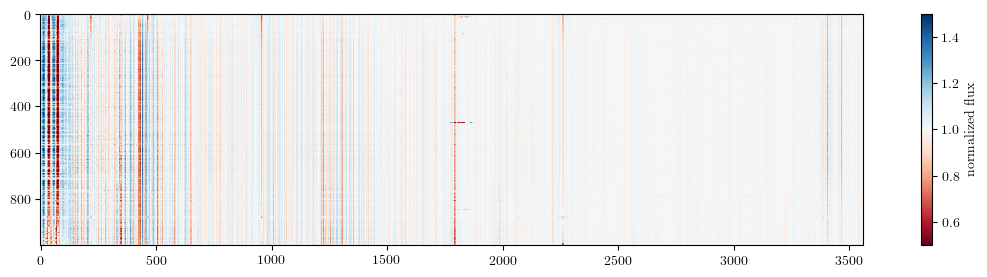

In [220]:
r = rand(1:size(spectra, 1), 1000)

Hα_ind = argmin(abs.(wl_grid .- 6565))
r = r[sortperm(spectra[r, Hα_ind])]

figure(figsize=(15, 3)) 
#pltmask = 6000 .< wl_grid .< 6800
pltmask = wl_grid .> 0
imshow(spectra[r, pltmask], vmin=0.5, vmax=1.5, cmap="RdBu")
colorbar(label="normalized flux")
tick_params(axis="y",which="both",bottom=false, labelbottom=false)
savefig("../../Desktop/imshow.png", bbox_inches="tight")

In [8]:
include("masstracks.jl")

overplot_eep (generic function with 1 method)

In [46]:
snrmask = enriched.snrr .> 100;
highsnr = view(spectra, snrmask,  :)
;

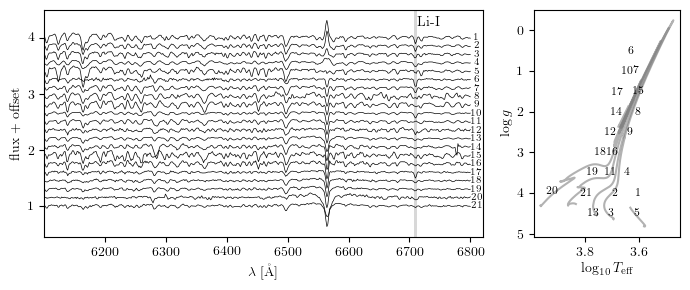

In [96]:
py"""
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 3))
gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=2, figure=fig, width_ratios=[3,1])

kielax = fig.add_subplot(gs[0])
specax = fig.add_subplot(gs[1])
"""

N = 15

sca(py"kielax")
r = []
#while (length(r) < N)
for teff in 3.4:0.1:4.0, logg in 0:0.5:5
    #teff, logg = [0.6, 5] .* rand(2) .+ [3.4, 0]
    dists = @. (teff - log10(enriched.teff[snrmask]))^2 + (logg - enriched.logg[snrmask])^2
    if minimum(dists) < 0.005
        push!(r, argmin(dists))
    end
end
Hα_ind = argmin(abs.(wl_grid .- 6565))
r = r[sortperm(highsnr[r, Hα_ind])]
r = r[2:end]
N = length(r)

pltmask = 6100 .< wl_grid .< 6800
offsets = collect(0:N-1)*0.15
plot(wl_grid[pltmask], (highsnr[r, pltmask] .+ offsets)', c="k", lw=0.5)
xlim(wl_grid[pltmask][1], wl_grid[pltmask][end] + N)
for (i, o) in zip(N:-1:1, offsets)
    text(wl_grid[pltmask][end] + 10, 1 + o, i, va="center", ha="center", size=7)
end
ylabel("flux + offset")
xlabel(L"$\lambda$ [\AA]")
tight_layout()
axvspan(li_vac-3, li_vac+3, ls="--", fc="grey", zorder=0, alpha=0.3)
text(li_vac+3.1, 4.2,"Li-I")
#ylim(ylim()[1], min(3.5,ylim()[2]))

sca(py"specax")
for (teff, logg, i) in zip(enriched.teff[snrmask][r], enriched.logg[snrmask][r], N:-1:1)
    text(log10(teff), logg, i, va="center", ha="center", size=8)
end
overplot_eep(eeps, :log_Teff, :log_g, label=false)
scatter(log10.(enriched.teff[snrmask][r]), enriched.logg[snrmask][r], c="white", zorder=-10)
gca().invert_yaxis()
gca().invert_xaxis()
xlabel(L"\log_{10} T_\mathrm{eff}")
ylabel(L"\log g")

tight_layout()
savefig("../../Desktop/sample_spectra.pdf", bbox_inches="tight")

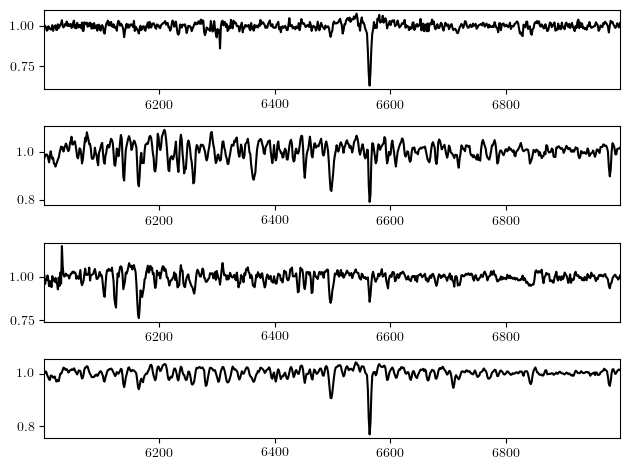

In [62]:
axs = subplots(4, 1)[2]
for ax in axs
    r = rand(1:size(spectra, 1))
    sca(ax)
    pltmask = 6000 .< wl_grid .< 7000
    plot(wl_grid[pltmask], spectra[r, pltmask], c="k")
    xlim(wl_grid[pltmask][1], wl_grid[pltmask][end])
end
tight_layout()